In [141]:
import torch
import numpy as np
import random
import zarr
from skimage.segmentation import relabel_sequential
from scipy.ndimage import distance_transform_edt, map_coordinates
from matplotlib import gridspec, ticker
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from torch.utils.data import DataLoader, random_split
import torch.nn as nn

import torchvision.transforms.v2 as transforms_v2


In [19]:
random.seed(26)
zarr_path = "/mnt/efs/aimbl_2025/student_data/S-DM/Data/zarr_storage/tauopathies.zarr"
root = zarr.open (zarr_path)
test_cond = random.choice (list(root.keys()))
test_image = random.choice (list (root[test_cond].keys()))
test_array = np.array (root[test_cond][test_image]["y_cropped"], dtype = "float32")
print (test_array.shape)
type (test_array)



(48, 512, 512)


numpy.ndarray

In [3]:
for i in range(test_array.shape[0]):
    print (test_array[i, :, :].mean(), test_array[i, :, :].max())

0.011599196 1.0
0.013041522 1.0
0.0155918645 1.0
0.012006618 0.99215686
0.012035878 0.8117647
0.012566121 0.99215686
0.011328305 0.9098039
0.0010609797 0.1882353
0.013272154 1.0
0.013541996 1.0
0.013846843 1.0
0.0123401 0.972549
0.013447841 1.0
0.01246688 0.69411767
0.01213458 0.84313726
0.0013976455 0.7921569
0.013047865 0.91764706
0.012833404 0.8627451
0.012203037 1.0
0.01292913 1.0
0.013346789 1.0
0.013234201 0.99215686
0.012294993 1.0
0.0011130241 0.17254902
0.013880488 1.0
0.012761824 1.0
0.012371931 0.94509804
0.011927318 0.7607843
0.013210969 0.99607843
0.014519621 0.84705883
0.016090738 1.0
0.001410301 0.6666667
0.01322623 0.9843137
0.01257088 0.96862745
0.0121872565 1.0
0.013231075 0.9254902
0.015709283 1.0
0.01680515 0.8862745
0.017726222 1.0
0.0016967922 0.21568628
0.0042117997 0.5921569
0.004247239 0.84705883
0.004166113 0.9019608
0.0041614757 0.21176471
0.005999771 1.0
0.005995867 1.0
0.005860961 1.0
0.0004989325 0.19607843


In [4]:
collapsed_array = test_array.sum(axis = 0)
print (collapsed_array.shape)
print (collapsed_array.max())

(512, 512)
2.3764722


In [5]:
start_index = 1
test_relab = test_array.copy()
print (test_relab.shape)
# for i in range(test_relab.shape[0]):
#     print (test_relab[i, :, :].max())
for i in range (test_relab.shape[0]):
    if test_relab [i, :, :].max() > 0:
        test_relab [i, :, :] = relabel_sequential (test_relab [i, :, :], offset = start_index)[0]
        start_index = test_relab [i, :, :].max()
    else:
        test_relab [i, :, :] = test_relab [i, :, :]

# relabelled_array = relabel_sequential(collapsed_array)[0]
# print (relabelled_array.max())
# 2729 //512
print (test_relab.shape)

(11, 2727, 3638)
(11, 2727, 3638)


In [6]:
relabel_sequential?

Signature: relabel_sequential(label_field, offset=1)
Docstring:
Relabel arbitrary labels to {`offset`, ... `offset` + number_of_labels}.

This function also returns the forward map (mapping the original labels to
the reduced labels) and the inverse map (mapping the reduced labels back
to the original ones).

Parameters
----------
label_field : numpy array of int, arbitrary shape
    An array of labels, which must be non-negative integers.
offset : int, optional
    The return labels will start at `offset`, which should be
    strictly positive.

Returns
-------
relabeled : numpy array of int, same shape as `label_field`
    The input label field with labels mapped to
    {offset, ..., number_of_labels + offset - 1}.
    The data type will be the same as `label_field`, except when
    offset + number_of_labels causes overflow of the current data type.
forward_map : ArrayMap
    The map from the original label space to the returned label
    space. Can be used to re-apply the same mappin

In [7]:
# def crop_tiles (image, crop_size):
#     h_tiles = (image.shape[0]//crop_size) + 1
#     v_tiles = (image.shape[1]//crop_size) + 1

#     new_h_shape = crop_size * h_tiles
#     new_v_shape = crop_size * v_tiles

#     new_image = np.zeros (shape = (new_h_shape, new_v_shape)) 
#     new_image[0:image.shape[0], 0:image.shape[1]] = image
#     tiles = []
#     for i in range (h_tiles):
#         for j in range (v_tiles):
#             y_start = i * crop_size
#             y_end = (i+1) * crop_size
#             x_start = j * crop_size
#             x_end = (j+1)* crop_size

#             tile = new_image [y_start:y_end , x_start:x_end]
#             tiles.append (tile)
    



#     return (np.stack (tiles))

# crop = crop_tiles (collapsed_array, 512)
# print (crop.shape)
# print (collapsed_array.shape)





In [8]:
# def crop_tiles_2(image, crop_size):
#     h, w = image.shape
#     h_tiles = (h + crop_size - 1) // crop_size  # ceil division
#     v_tiles = (w + crop_size - 1) // crop_size

#     # Pad only if needed
#     pad_h = h_tiles * crop_size - h
#     pad_w = v_tiles * crop_size - w
#     if pad_h > 0 or pad_w > 0:
#         image = np.pad(image, ((0, pad_h), (0, pad_w)), mode='constant')

#     # Preallocate output array
#     tiles = np.empty((h_tiles * v_tiles, crop_size, crop_size), dtype=image.dtype)

#     idx = 0
#     for i in range(h_tiles):
#         for j in range(v_tiles):
#             y_start = i * crop_size
#             x_start = j * crop_size
#             tiles[idx] = image[y_start:y_start + crop_size, x_start:x_start + crop_size]
#             idx += 1

#     return tiles

# crop_2 = crop_tiles_2 (collapsed_array, 512)
# print (crop_2.shape)
# print (collapsed_array.shape)

In [9]:
# def load_data(zarr_path, crop_size):
#     root = zarr.open(zarr_path, mode='r')

#     # list of diseases
#     diseases = root.keys()
#     x_list = []
#     y_list = []
#     for d in diseases:
#         for fov in root[d].keys():
#             x = root[d][fov]['x'][:]
#             y = root[d][fov]['y'][:].astype ("int64")

#             # Preprocessing
#             start_index = 1
#             for i in range (y.shape[0]):
#                 if y [i, :, :].max() > 0:
#                     y [i, :, :] = relabel_sequential (y [i, :, :], offset = start_index)[0]
#                     start_index = y [i, :, :].max()
#                 else:
#                     y [i, :, :] = y [i, :, :]
#             # collapse masks
#             y_collapsed = y.sum(axis = 0)
            
#             # tile x and y
#             x_processed = crop_tiles_2 (x, crop_size)
#             y_processed = crop_tiles_2 (y_collapsed, crop_size)

#             x_list.append(x_processed)
#             y_list.append(y_processed)

#     x = np.concatenate(x_list, axis = 0)
#     y = np.concatenate(y_list, axis = 0)
#     return x, y 

In [10]:
# load = load_data (zarr_path, crop_size = 512)

In [11]:
# print (np.zeros (shape = (512, 512)))

In [142]:
def load_data (zarr_path):
    x_arrays = []
    y_arrays = []
    root = zarr.open (zarr_path)
    for conditions in list (root.keys()):
        images = root [conditions].keys()
        for fov in images:
            x = root[conditions][fov]["x_cropped"][:].astype ("float32")
            y = root[conditions][fov]["y_cropped"][:].astype ("int16")
            #y1 = root[conditions][fov]["y_cropped"][:].astype ("int64")
            #assert (y == y1).all()
            # print (x.dtype, y.dtype)
            x_arrays.append (x)
            y_arrays.append (y)
    x_array = np.concatenate (x_arrays)
    y_array = np.concatenate (y_arrays)
    return x_array, y_array




In [13]:
# load = load_data (zarr_path)
# print (load[0].shape)
# print (load[1].shape)
# print (len (load[0]))
# print (load[0][0].shape)


In [14]:
# import random
# import matplotlib.pyplot as plt
# from matplotlib.colors import ListedColormap

# index = random.choice (range (0, load[0].shape[0]))
# x = load[0][index, :, :]
# y = load [1][index, :, :]

# fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# axes[0].imshow(x, cmap="gray")
# axes[0].set_title(f"X")
# axes[0].axis("off")
    
# axes[1].imshow(y, cmap="tab20")
# axes[1].set_title(f"Y")
# axes[1].axis("off")
    
# plt.show()

In [143]:
def compute_sdt(labels: np.ndarray, scale: int = 5):
    """Function to compute a signed distance transform."""
    dims = len(labels.shape)
    # Create a placeholder array of infinite distances
    distances = np.ones(labels.shape, dtype=np.float32) * np.inf
    for axis in range(dims):
        # Here we compute the boundaries by shifting the labels and comparing to the original labels
        # This can be visualized in 1D as:
        # a a a b b c c c
        #   a a a b b c c c
        #   1 1 0 1 0 1 1
        # Applying a half pixel shift makes the result more obvious:
        # a a a b b c c c
        #  1 1 0 1 0 1 1
        bounds = (
            labels[*[slice(None) if a != axis else slice(1, None) for a in range(dims)]]
            == labels[
                *[slice(None) if a != axis else slice(None, -1) for a in range(dims)]
            ]
        )
        # pad to account for the lost pixel
        bounds = np.pad(
            bounds,
            [(1, 1) if a == axis else (0, 0) for a in range(dims)],
            mode="constant",
            constant_values=1,
        )
        # compute distances on the boundary mask
        axis_distances = distance_transform_edt(bounds)

        # compute the coordinates of each original pixel relative to the boundary mask and distance transform.
        # Its just a half pixel shift in the axis we computed boundaries for.
        coordinates = np.meshgrid(
            *[
                (
                    range(axis_distances.shape[a])
                    if a != axis
                    else np.linspace(
                        0.5, axis_distances.shape[a] - 1.5, labels.shape[a]
                    )
                )
                for a in range(dims)
            ],
            indexing="ij",
        )
        coordinates = np.stack(coordinates)

        # Interpolate the distances to the original pixel coordinates
        sampled = map_coordinates(
            axis_distances,
            coordinates=coordinates,
            order=3,
        )

        # Update the distances with the minimum distance to a boundary in this axis
        distances = np.minimum(distances, sampled)

    # Normalize the distances to be between -1 and 1
    distances = np.tanh(distances / scale)

    # Invert the distances for pixels in the background
    distances[labels == 0] *= -1
    return distances

In [43]:
a = compute_sdt(test_array)


In [44]:
a.shape

(48, 512, 512)

In [144]:
import os
from torchvision.io import decode_image 
from torch.utils.data import Dataset


class CropDataset(Dataset):
    def __init__(self, zarr_path, transform = None, img_transform = None):
        
        
        self.zarr_path = zarr_path

        self.x, self.y = load_data(self.zarr_path)
        self.transform = transform
        self.img_transform = img_transform
        
       

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        img = self.x[idx]  
        seg = self.y[idx] 

        img = torch.tensor(img).unsqueeze(0)
        seg = torch.tensor(seg).unsqueeze(0)
        sdt = torch.tensor (compute_sdt (seg))
        
        if self.transform:
            seed = torch.seed()
            torch.manual_seed(seed)
            img = self.transform (img)
            torch.manual_seed(seed)
            seg = self.transform(seg)
            torch.manual_seed(seed)
            sdt = self.transform(sdt)
            # img, sdt, seg = self.transform (img, sdt, seg)
        
        if self.img_transform:
            img = self.img_transform(img)

        

    

        return torch.tensor(img, dtype=torch.float32), torch.tensor(sdt, dtype=torch.float32)

In [145]:
dataset = CropDataset (zarr_path=zarr_path)



In [189]:
def plot_two(img: np.ndarray, intermediate: np.ndarray, label: str):
    """
    Helper function to plot an image and the auxiliary (intermediate)
    representation of the target.
    """
    if img.shape[0] == 2 and len(img.shape) == 3:
        img = np.array([img[0], img[1], img[0] * 0]).transpose((1, 2, 0))
    if intermediate.shape[0] == 4 and len(intermediate.shape) == 3:
        intermediate = np.array(
            [
                (intermediate[0] + intermediate[2]) / 2,
                (intermediate[1] + intermediate[3]) / 2,
                intermediate.sum(axis=0) > 0,  # any affinity is 1
            ]
        ).transpose((1, 2, 0))
    fig = plt.figure(constrained_layout=False, figsize=(10, 3))
    spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)
    ax1 = fig.add_subplot(spec[0, 0])
    ax1.set_xlabel("Image", fontsize=20)
    plt.imshow(img)
    ax2 = fig.add_subplot(spec[0, 1])
    ax2.set_xlabel(label, fontsize=20)
    if len(intermediate.shape) == 2:
        t = plt.imshow(intermediate, cmap="coolwarm")
        cbar = fig.colorbar(t, fraction=0.046, pad=0.04)
        tick_locator = ticker.MaxNLocator(nbins=3)
        cbar.locator = tick_locator
        cbar.update_ticks()
        _ = [ax.set_xticks([]) for ax in [ax1, ax2]]
        _ = [ax.set_yticks([]) for ax in [ax1, ax2]]
    elif len(intermediate.shape) == 3:
        plt.imshow(intermediate)

    plt.tight_layout()
    plt.show()

def plot_three(
    img: np.ndarray,
    intermediate: np.ndarray,
    pred: np.ndarray,
    label: str = "Target",
    label_cmap=None,
):
    """
    Helper function to plot an image, the auxiliary (intermediate)
    representation of the target and the model prediction.
    """
    if img.shape[0] == 2 and len(img.shape) == 3:
        img = np.array([img[0], img[1], img[0] * 0]).transpose((1, 2, 0))
    if intermediate.shape[0] == 4 and len(intermediate.shape) == 3:
        intermediate = np.array(
            [
                (intermediate[0] + intermediate[2]) / 2,
                (intermediate[1] + intermediate[3]) / 2,
                intermediate.sum(axis=0) > 0,  # any affinity is 1
            ]
        ).transpose((1, 2, 0))
    if pred.shape[0] == 4 and len(pred.shape) == 3:
        pred = np.array(
            [(pred[0] + pred[2]) / 2, (pred[1] + pred[3]) / 2, pred.mean(axis=0)]
        ).transpose((1, 2, 0))
    fig = plt.figure(constrained_layout=False, figsize=(10, 3))
    spec = gridspec.GridSpec(ncols=3, nrows=1, figure=fig)
    ax1 = fig.add_subplot(spec[0, 0])
    ax1.set_xlabel("Image", fontsize=20)
    plt.imshow(img)
    ax2 = fig.add_subplot(spec[0, 1])
    if label_cmap is not None:
        ax2.set_xlabel("Labels", fontsize=20)
    else:
        ax2.set_xlabel(label, fontsize=20)

    if len(intermediate.shape) == 2:
        if label_cmap is None:
            plt.imshow(intermediate, cmap="coolwarm")
        else:
            plt.imshow(intermediate, cmap=label_cmap, interpolation="none")
    else:
        plt.imshow(intermediate)
    ax3 = fig.add_subplot(spec[0, 2])
    if label_cmap is not None:
        ax3.set_xlabel(label, fontsize=20)
    else:
        ax3.set_xlabel("Prediction", fontsize=20)

    if len(pred.shape) == 2:
        t = plt.imshow(pred, cmap="coolwarm")
        cbar = fig.colorbar(t, fraction=0.046, pad=0.04)
        tick_locator = ticker.MaxNLocator(nbins=3)
        cbar.locator = tick_locator
        cbar.update_ticks()
        _ = [ax.set_xticks([]) for ax in [ax1, ax2, ax3]]  # remove the xticks
        _ = [ax.set_yticks([]) for ax in [ax1, ax2, ax3]]  # remove the yticks
    else:
        plt.imshow(pred)
    plt.tight_layout()
    plt.show()


In [32]:
type (dataset[0][0])

/tmp/ipykernel_494074/1195748737.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(img, dtype=torch.float32), torch.tensor(sdt, dtype=torch.float32)


torch.Tensor

/tmp/ipykernel_498616/2591896451.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(img, dtype=torch.float32), torch.tensor(sdt, dtype=torch.float32)


torch.Size([512, 512])
torch.Size([512, 512])


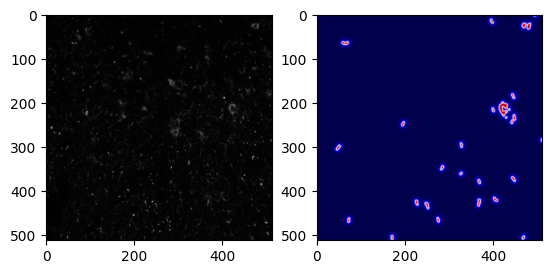

In [181]:
index = random.choice (range(0, len (dataset)))
img = dataset [index][0].squeeze(0)
print (img.shape)
sdt = dataset[index][1].squeeze (0)
print (sdt.shape) # get the image and the distance transform
# We use the <code style="color: black">plot_two</code> function (imported in the first cell) to verify that our
# dataset solution is correct. The output should show 2 images: the raw image and
# the corresponding SDT.
# plot_two(img, sdt,  label="SDT")
# sdt.shape

fig, ax = plt.subplots(1,2)
ax[0].imshow(img, cmap = "grey")
ax[1].imshow(sdt, cmap = "seismic")


In [135]:
torch.manual_seed (41)
np.random.seed(42)

training, validation = random_split(dataset, lengths = (0.2, 0.8))
print (len (training), len (validation))
print (training[1])


864 3452
(tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0235, 0.0314, 0.0275,  ..., 0.0000, 0.0000, 0.0000],
         [0.0118, 0.0353, 0.0314,  ..., 0.0275, 0.0353, 0.0353],
         ...,
         [0.0000, 0.0000, 0.0196,  ..., 0.0039, 0.0196, 0.0157],
         [0.0000, 0.0000, 0.0039,  ..., 0.0275, 0.0353, 0.0196],
         [0.0000, 0.0000, 0.0000,  ..., 0.0392, 0.0275, 0.0078]]]), tensor([[[-0.2913, -0.3496, -0.4672,  ..., -1.0000, -1.0000, -1.0000],
         [-0.3496, -0.3954, -0.4967,  ..., -1.0000, -1.0000, -1.0000],
         [-0.4672, -0.4967, -0.5692,  ..., -1.0000, -1.0000, -1.0000],
         ...,
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]]))


/tmp/ipykernel_498616/2591896451.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(img, dtype=torch.float32), torch.tensor(sdt, dtype=torch.float32)


In [186]:
train_dataloader = DataLoader (training, shuffle=True)

In [166]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [167]:
from dlmbl_unet import UNet
import torch.nn as nn
model = UNet(
    depth = 4,
    in_channels=1,
    out_channels=1,
    final_activation=nn.Tanh(),
    num_fmaps=16
)

learning_rate = 1e-4
loss = nn.MSELoss()
optimizer = torch.optim.Adam (model.parameters(), lr = learning_rate)

In [28]:
def train(
    model,
    loader,
    optimizer,
    loss_function,
    epoch,
    log_interval=100,
    log_image_interval=20,
    tb_logger=None,
    device=None,
    early_stop=False,
):
    if device is None:
        # You can pass in a device or we will default to using
        # the gpu. Feel free to try training on the cpu to see
        # what sort of performance difference there is
        if torch.cuda.is_available():
            device = torch.device("cuda")
        else:
            device = torch.device("cpu")

    # set the model to train mode
    model.train()

    # move model to device
    model = model.to(device)

    # iterate over the batches of this epoch
    for batch_id, (x, y) in enumerate(loader):
        # move input and target to the active device (either cpu or gpu)
        x, y = x.to(device), y.to(device)

        # zero the gradients for this iteration
        optimizer.zero_grad()

        # apply model and calculate loss
        prediction = model(x)
        # if necessary, crop the masks to match the model output shape
        if prediction.shape != y.shape:
            y = center_crop(y, prediction.size()[2:])
        if y.dtype != prediction.dtype:
            y = y.type(prediction.dtype)
        loss = loss_function(prediction, y)

        # backpropagate the loss and adjust the parameters
        loss.backward()
        optimizer.step()

        # log to console
        if batch_id % log_interval == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_id * len(x),
                    len(loader.dataset),
                    100.0 * batch_id / len(loader),
                    loss.item(),
                )
            )

        # log to tensorboard
        if tb_logger is not None:
            step = epoch * len(loader) + batch_id
            tb_logger.add_scalar(
                tag="train_loss", scalar_value=loss.item(), global_step=step
            )
            # check if we log images in this iteration
            if step % log_image_interval == 0:
                x = unnormalize(x)
                tb_logger.add_images(
                    tag="input", img_tensor=x.to("cpu"), global_step=step
                )
                tb_logger.add_images(
                    tag="target", img_tensor=y.to("cpu"), global_step=step
                )
                tb_logger.add_images(
                    tag="prediction",
                    img_tensor=prediction.to("cpu").detach(),
                    global_step=step,
                )
                combined_image = torch.cat(
                    [x, pad_to_size(y, x.size()), pad_to_size(prediction, x.size())],
                    dim=3,
                )

                tb_logger.add_images(
                    tag="input_target_prediction",
                    img_tensor=combined_image,
                    global_step=step,
                )

        if early_stop and batch_id > 5:
            print("Stopping test early!")
            break

In [37]:
# Now lets start experimenting. Start a tensorboard logger to keep track of experiments.
# start a tensorboard writer
from torch.utils.tensorboard import SummaryWriter
from torch.utils.tensorboard import SummaryWriter
logger = SummaryWriter("runs/Unet")


# Function to find an available port and launch TensorBoard on the browser
def launch_tensorboard(log_dir):
    import socket

    with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
        s.bind(("", 0))
        port = s.getsockname()[1]

    tensorboard_cmd = f"tensorboard --logdir={log_dir} --port={port}"
    process = subprocess.Popen(tensorboard_cmd, shell=True)
    print(
        f"TensorBoard started at http://localhost:{port}. \n"
        "If you are using VSCode remote session, forward the port using the PORTS tab next to TERMINAL."
    )
    return process


launch_tensorboard("runs")

ModuleNotFoundError: No module named 'tensorboard'

In [30]:
for epoch in range(10):
    train (model= model,
           loader = train_dataloader,
            optimizer = optimizer,
            loss_function = loss, epoch = epoch, device=device)

/tmp/ipykernel_463690/1195748737.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(img, dtype=torch.float32), torch.tensor(sdt, dtype=torch.float32)


Train Epoch: 0 [0/3453 (0%)]	Loss: 2.783977
Train Epoch: 0 [100/3453 (3%)]	Loss: 0.041473
Train Epoch: 0 [200/3453 (6%)]	Loss: 0.028584
Train Epoch: 0 [300/3453 (9%)]	Loss: 0.045519
Train Epoch: 0 [400/3453 (12%)]	Loss: 0.185807
Train Epoch: 0 [500/3453 (14%)]	Loss: 0.575864
Train Epoch: 0 [600/3453 (17%)]	Loss: 0.004985
Train Epoch: 0 [700/3453 (20%)]	Loss: 0.019377
Train Epoch: 0 [800/3453 (23%)]	Loss: 0.010743
Train Epoch: 0 [900/3453 (26%)]	Loss: 0.102288
Train Epoch: 0 [1000/3453 (29%)]	Loss: 0.004830
Train Epoch: 0 [1100/3453 (32%)]	Loss: 0.013287
Train Epoch: 0 [1200/3453 (35%)]	Loss: 0.001311
Train Epoch: 0 [1300/3453 (38%)]	Loss: 0.000010
Train Epoch: 0 [1400/3453 (41%)]	Loss: 0.138864
Train Epoch: 0 [1500/3453 (43%)]	Loss: 0.000857
Train Epoch: 0 [1600/3453 (46%)]	Loss: 0.030425
Train Epoch: 0 [1700/3453 (49%)]	Loss: 0.000675
Train Epoch: 0 [1800/3453 (52%)]	Loss: 0.002814
Train Epoch: 0 [1900/3453 (55%)]	Loss: 0.025728


KeyboardInterrupt: 

/tmp/ipykernel_498616/2591896451.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(img, dtype=torch.float32), torch.tensor(sdt, dtype=torch.float32)


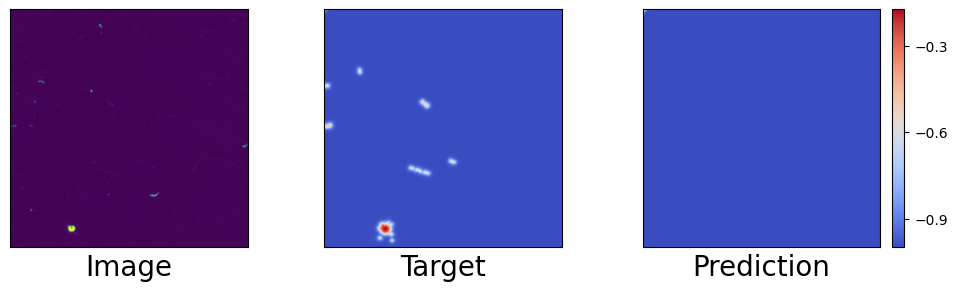

In [219]:
validation_dataloader = DataLoader(validation)
model.eval()
idx = np.random.randint(len(validation))  # take a random sample.
image, sdt = validation[idx]  # get the image and the nuclei masks.
image = image.to(device)
pred = model (torch.unsqueeze(image, dim=0))
image = np.squeeze(image.cpu())
sdt = np.squeeze(sdt.cpu().numpy())
pred = np.squeeze(pred.cpu().detach().numpy())
plot_three(image, sdt, pred)

In [202]:
model = UNet(
    depth = 4,
    in_channels=1,
    out_channels=1,
    final_activation=nn.Tanh(),
    num_fmaps=16)

learning_rate = 1e-4
optimizer = torch.optim.Adam (model.parameters(), lr = learning_rate)

checkpoint = torch.load ("/mnt/efs/aimbl_2025/student_data/S-DM/Data/checkpoints/unet_2.pth")
model.load_state_dict (checkpoint['unet'])

<All keys matched successfully>

/tmp/ipykernel_498616/2591896451.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(img, dtype=torch.float32), torch.tensor(sdt, dtype=torch.float32)


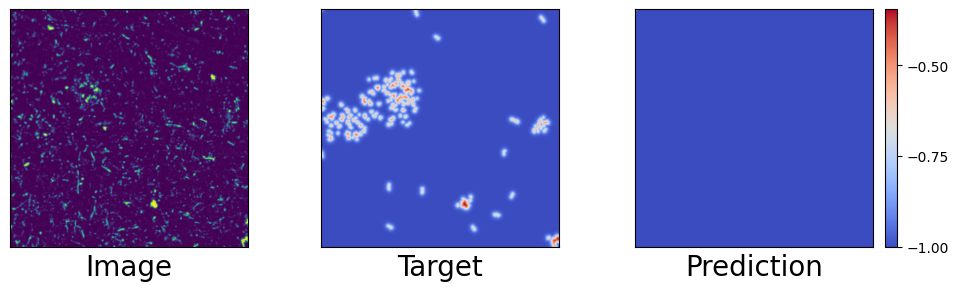

In [221]:

training_dataloader = DataLoader(training)
model.eval()
idx = np.random.randint(len(training))  # take a random sample.
image, sdt = training[idx]  # get the image and the nuclei masks.
image = image.to(device)
model = model.to (device)
pred = model (torch.unsqueeze(image, dim=0))
image = np.squeeze(image.cpu())
sdt = np.squeeze(sdt.cpu().numpy())
pred = np.squeeze(pred.cpu().detach().numpy())
plot_three(image, sdt, pred)